### Цели и задачи проекта
Цель проекта - отследить влияние условий жизни учеников школы в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять учеников, находящихся в группе риска. Для этого необходимо построить модель, которая предсказывала бы результат госэкзамена по математике для каждого ученика.

### Первичная обработка данных
Импортируем библиотеки

In [1]:
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import ttest_ind

pd.options.display.max_columns = 40

Читаем данные из файла

In [2]:
data = pd.read_csv('stud_math.xls')

Проверяем названия переменных датасета и переименовываем при необходимости

In [3]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [4]:
data.rename(columns={'studytime, granular': 'Gstudytime'}, inplace=True)

Отображаем основную информацию по датасету

In [5]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,Gstudytime,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int64  
 3   address     378 non-null    object 
 4   famsize     368 non-null    object 
 5   Pstatus     350 non-null    object 
 6   Medu        392 non-null    float64
 7   Fedu        371 non-null    float64
 8   Mjob        376 non-null    object 
 9   Fjob        359 non-null    object 
 10  reason      378 non-null    object 
 11  guardian    364 non-null    object 
 12  traveltime  367 non-null    float64
 13  studytime   388 non-null    float64
 14  failures    373 non-null    float64
 15  schoolsup   386 non-null    object 
 16  famsup      356 non-null    object 
 17  paid        355 non-null    object 
 18  activities  381 non-null    object 
 19  nursery     379 non-null    o

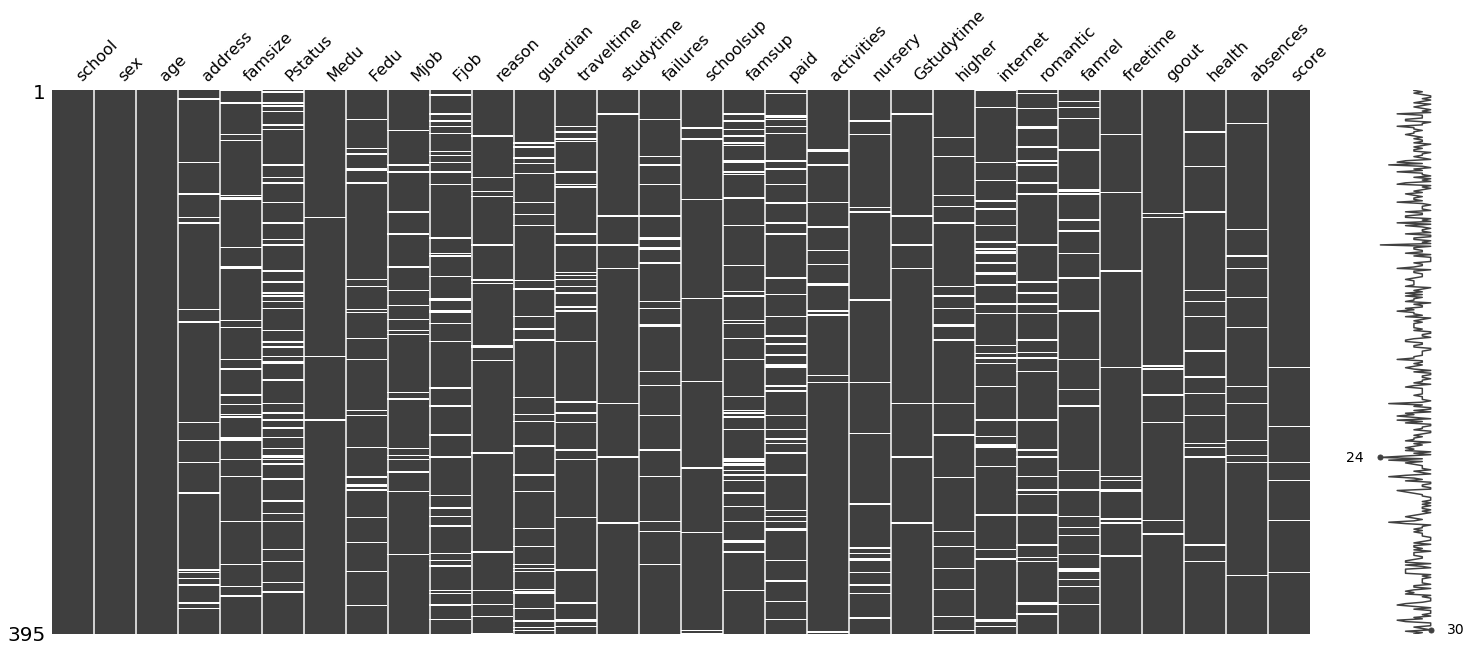

In [7]:
msno.matrix(data);

Переменные делятся на три типа:
- числовые: 'age', 'absences', 'score'.
- ординальные: 'Medu', 'Fedu', 'traveltime', studytime', 'failures', 'famrel', 'freetime', 'goout', 'health'.
- категориальные: 'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', paid', 'activities', 'nursery', higher', 'internet', 'romantic'.

Про переменную 'Gstudytime' мы пока мало знаем и не можем точно определить её тип.

Максимальная доля пустых значений - 10,1 % (у переменной 'paid').

### Просмотр уникальных значений
Просматриваем количество уникальных значений категориальных переменных

In [8]:
for column in data.columns:
    if data[column].dtype == 'O':
        print(column.join(['', ':']).ljust(12), end='')
        print(data[column].nunique())

school:     2
sex:        2
address:    2
famsize:    2
Pstatus:    2
Mjob:       5
Fjob:       5
reason:     4
guardian:   3
schoolsup:  2
famsup:     2
paid:       2
activities: 2
nursery:    2
higher:     2
internet:   2
romantic:   2


Просматриваем сами уникальные значения категориальных переменных

In [9]:
for column in data.columns:
    if data[column].dtype == 'O':
        print(column.join(['', ':']).ljust(12), end='')
        print(data[column].unique())

school:     ['GP' 'MS']
sex:        ['F' 'M']
address:    ['U' nan 'R']
famsize:    [nan 'GT3' 'LE3']
Pstatus:    ['A' nan 'T']
Mjob:       ['at_home' 'health' 'other' 'services' 'teacher' nan]
Fjob:       ['teacher' 'other' nan 'health' 'services' 'at_home']
reason:     ['course' 'other' 'home' 'reputation' nan]
guardian:   ['mother' 'father' 'other' nan]
schoolsup:  ['yes' 'no' nan]
famsup:     ['no' 'yes' nan]
paid:       ['no' nan 'yes']
activities: ['no' 'yes' nan]
nursery:    ['yes' 'no' nan]
higher:     ['yes' nan 'no']
internet:   [nan 'yes' 'no']
romantic:   ['no' nan 'yes']


Просматриваем количество уникальных значений числовых и ординальных переменных

In [10]:
for column in data.columns:
    if data[column].dtype != 'O':
        print(column.join(['', ':']).ljust(12), end='')
        print(data[column].nunique())

age:        8
Medu:       5
Fedu:       6
traveltime: 4
studytime:  4
failures:   4
Gstudytime: 4
famrel:     6
freetime:   5
goout:      5
health:     5
absences:   36
score:      18


Просматриваем уникальные значения числовых и ординальных переменных (в данном случае уникальных значений для них не много)

In [11]:
for column in data.columns:
    if data[column].dtype != 'O':
        print(column.join(['', ':']).ljust(12), end='')
        print(np.sort(data[column].unique()))

age:        [15 16 17 18 19 20 21 22]
Medu:       [ 0.  1.  2.  3.  4. nan]
Fedu:       [ 0.  1.  2.  3.  4. 40. nan]
traveltime: [ 1.  2.  3.  4. nan]
studytime:  [ 1.  2.  3.  4. nan]
failures:   [ 0.  1.  2.  3. nan]
Gstudytime: [-12.  -9.  -6.  -3.  nan]
famrel:     [-1.  1.  2.  3.  4.  5. nan]
freetime:   [ 1.  2.  3.  4.  5. nan]
goout:      [ 1.  2.  3.  4.  5. nan]
health:     [ 1.  2.  3.  4.  5. nan]
absences:   [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  28.
  30.  38.  40.  54.  56.  75. 212. 385.  nan]
score:      [  0.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.  80.
  85.  90.  95. 100.  nan]


Из уникальных значений видно:
- для многих переменных обнаружены значения NaN;
- обнаружены неверные значения у переменных 'Fedu' и 'famrel';
- переменная 'score' имеет кратность 5.

### Обработка неверных (ошибочных) значений
Проводим замену неверных значений на NaN для переменных с ограниченным набором возможных значений

In [12]:
# Fill the dict with possible column values
possible_vals = {
    'school': ['GP', 'MS'],
    'sex': ['F', 'M'],
    'age': range(15, 23),
    'address': ['U', 'R'],
    'famsize': ['GT3', 'LE3'],
    'Pstatus': ['A', 'T'],
    'Medu': range(0, 5),
    'Fedu': range(0, 5),
    'Mjob': ['at_home', 'health', 'services', 'teacher', 'other'],
    'Fjob': ['at_home', 'health', 'services', 'teacher', 'other'],
    'reason': ['course', 'home', 'reputation', 'other'],
    'guardian': ['mother', 'father', 'other'],
    'traveltime': range(1, 5),
    'studytime': range(1, 5),
    'failures': range(0, 5),
    'schoolsup': ['yes', 'no'],
    'famsup': ['yes', 'no'],
    'paid': ['yes', 'no'],
    'activities': ['yes', 'no'],
    'nursery': ['yes', 'no'],
    'higher': ['yes', 'no'],
    'internet': ['yes', 'no'],
    'romantic': ['yes', 'no'],
    'famrel': range(1, 6),
    'freetime': range(1, 6),
    'goout': range(1, 6),
    'health': range(1, 6),
}

In [13]:
for column, vals in possible_vals.items():
    # Add NaN to list
    vals = list(vals)
    vals.append(np.nan)
    
    # Replace values
    mask = data[column].isin(vals)
    data[column].where(mask, inplace=True)
    
    # Show the result
    replaced_num = data[column].shape[0] - mask.sum()
    if replaced_num:
        print(f"{str(replaced_num).ljust(3)} cells have been replaced with NaN in column '{column}'")

1   cells have been replaced with NaN in column 'Fedu'
1   cells have been replaced with NaN in column 'famrel'


Неверных замененных значений не много, следовательно, всё в порядке и можно переходить к следующему этапу

### Обработка выбросов
Строим боксплоты числовых переменных и проверяем их на наличие выбросов

In [14]:
# Fill the list of columns with quantity variables
quantity_cols = [
    'age',
    'absences',
    'score',
]

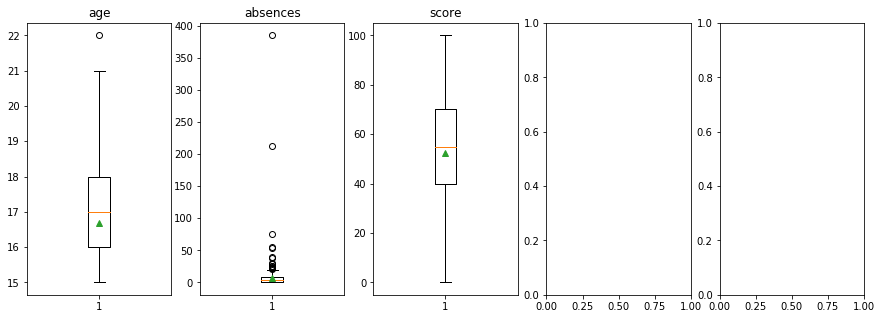

In [15]:
# Create figure with [rows x cols] graphs
cols = 5
rows = len(quantity_cols)//cols + 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*5))

# Plot graphs
i = 0
for column in quantity_cols:
    if rows == 1:
        idx = i%cols
    else:
        idx = (i//cols, i%cols)
    axs[idx].boxplot(data.loc[data[column].notna(), column], showmeans=True)
    axs[idx].set_title(column)
    i += 1

Из графиков видно:
- наблюдаются выбросы для числовых переменных 'age' и 'absences'.

Проводим замену выбросов на NaN только для числовых переменных ('age', 'absences', 'score')

In [16]:
for column in quantity_cols:
    # Calculate NaNs, Q1, Q3, IQR
    NaN_count = data[column].isna().sum()
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Replace values
    mask = data[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
    data[column].where(mask, inplace=True)

    # Show the result
    replaced_num = data[column].shape[0] - mask.sum() - NaN_count
    if replaced_num:
        print(f"{str(replaced_num).ljust(3)} cells have been replaced with NaN in column '{column}'")

1   cells have been replaced with NaN in column 'age'
17  cells have been replaced with NaN in column 'absences'


### Просмотр гистограмм (распределений)
Просматриваем распределения числовых и ординальных переменных

In [17]:
# Fill the list of bin numbers of quantity columns
quantity_bins = {
    'age': int(data['age'].max() - data['age'].min() + 1),
    'absences': 10,
    'score': int((data['score'].max() - data['score'].min())/5 + 1),
}

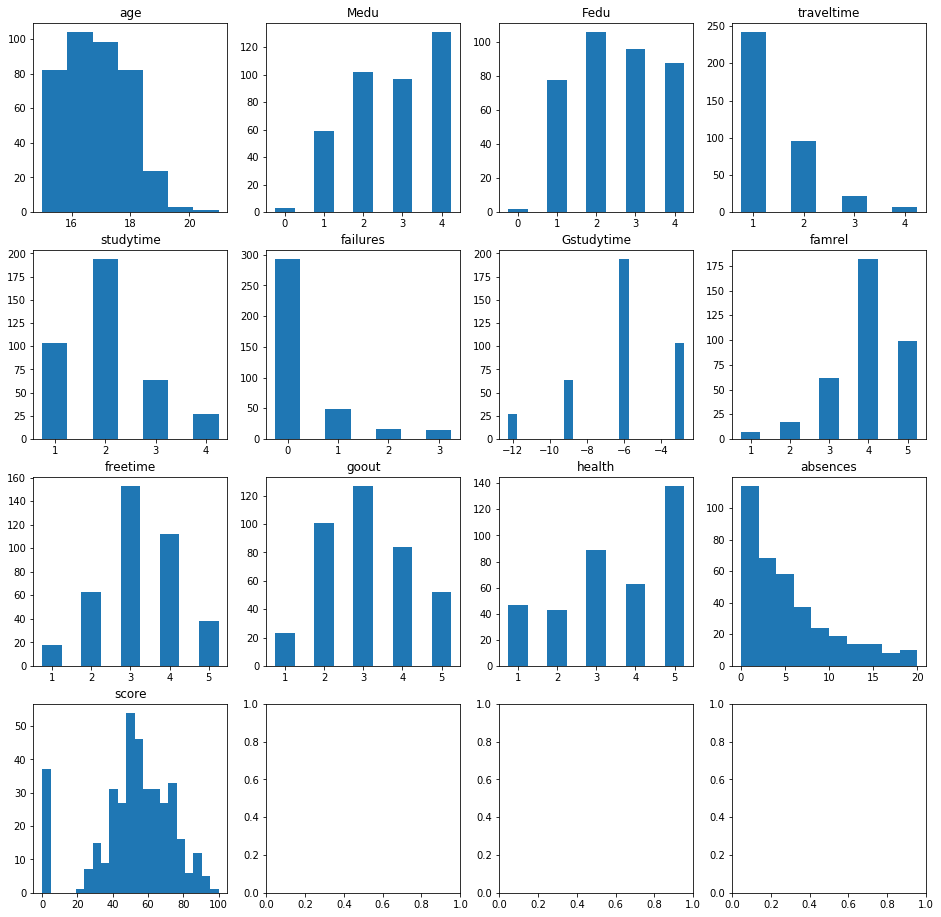

In [18]:
# Calculate number of graphs to plot
graphs_num = 0
for column in data.columns:
    if data[column].dtype != 'O':
        graphs_num += 1

# Create figure with [rows x cols] graphs
cols = 4
rows = graphs_num//cols + 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

# Plot graphs
i = 0
for column in data.columns:
    if data[column].dtype != 'O':
        # Calculate indexes of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
            
        # Calculate number of bins and ranges
        if column in quantity_cols:
            bins = quantity_bins[column]
            range_ = None
        else:
            col_max = data[column].max()
            col_min = data[column].min()
            bins = int(col_max - col_min)*2 + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        
        # Plot
        axs[idx].hist(data.loc[data[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        i += 1

Из графиков видно:
- распределение отличается от нормального для переменных 'Medu', 'traveltime', 'failures', 'health', 'absences';
- у переменной 'score' наблюдается разрыв значений между нулем и 20 баллами. Видимо все те, кто получил менее 20 баллов (или не явились на экзамен) имеют незачет, и их результат приравняли нулю.

### Корреляционный анализ
Выясним, какие переменные коррелируют с набранным количеством баллов на госэкзамене по математике ('score'). Это поможет выявить переменные, которые стоит оставить для построения модели предсказания.

Рассчитываем матрицу корреляций

In [19]:
corr_table = data.corr()
corr_table

,age,Medu,Fedu,traveltime,studytime,failures,Gstudytime,famrel,freetime,goout,health,absences,score
age,1.000000,-0.167883,-0.147779,0.090864,-0.002354,0.195891,0.002354,0.051487,0.021067,0.119997,-0.047402,0.129016,-0.153518
Medu,-0.167883,1.000000,0.629956,-0.173515,0.078589,-0.245463,-0.078589,-0.020896,0.025335,0.064164,-0.045051,0.065712,0.213349
Fedu,-0.147779,0.629956,1.000000,-0.155459,0.008603,-0.271936,-0.008603,-0.035788,-0.021415,0.046581,0.022588,-0.021415,0.130002
traveltime,0.090864,-0.173515,-0.155459,1.000000,-0.102206,0.064699,0.102206,-0.028220,-0.021937,0.037636,-0.021531,-0.047995,-0.070559
studytime,-0.002354,0.078589,0.008603,-0.102206,1.000000,-0.178992,-1.000000,0.028918,-0.121969,-0.051280,-0.080016,-0.078099,0.115741
failures,0.195891,-0.245463,-0.271936,0.064699,-0.178992,1.000000,0.178992,0.011942,0.098382,0.120914,0.081284,0.081801,-0.344338
Gstudytime,0.002354,-0.078589,-0.008603,0.102206,-1.000000,0.178992,1.000000,-0.028918,0.121969,0.051280,0.080016,0.078099,-0.115741
famrel,0.051487,-0.020896,-0.035788,-0.028220,0.028918,0.011942,-0.028918,1.000000,0.164324,0.069241,0.097910,-0.073509,0.051219
freetime,0.021067,0.025335,-0.021415,-0.021937,-0.121969,0.098382,0.121969,0.164324,1.000000,0.296437,0.061575,0.093436,0.019026
goout,0.119997,0.064164,0.046581,0.037636,-0.051280,0.120914,0.051280,0.069241,0.296437,1.000000,-0.015608,0.111587,-0.129685


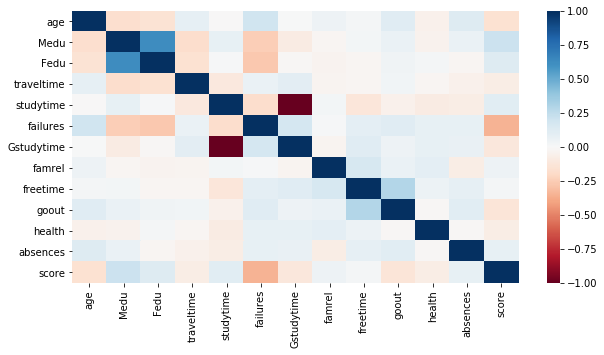

In [20]:
plt.subplots(figsize=(10, 5))
sns.heatmap(corr_table, cmap="RdBu");

Из полученных значений видно:
- переменная 'Gstudytime' полностью коррелирует с переменной 'studytime', а значит, одну из них можно удалить;
- сильно коррелируют переменные 'Fedu' и 'Medu'. Удалим переменную 'Fedu', так как она слабее коррелирует со 'score'.

Удаляем переменные 'Gstudytime' и 'Fedu'

In [21]:
data.drop(columns=['Gstudytime', 'Fedu'], inplace=True)

Сортируем значения корреляций со 'score' по модулю

In [22]:
corr_table['score'].abs().sort_values(ascending=False)

score         1.000000
failures      0.344338
Medu          0.213349
age           0.153518
Fedu          0.130002
goout         0.129685
studytime     0.115741
Gstudytime    0.115741
absences      0.081274
traveltime    0.070559
health        0.070460
famrel        0.051219
freetime      0.019026
Name: score, dtype: float64

Из полученных значений видно:
- переменная набранных баллов 'score' почти не коррелирует с переменной свободного времени ученика 'freetime'.

Удаляем переменную 'freetime'

In [23]:
data.drop(columns='freetime', inplace=True)

### Анализ категориальных переменных
Очевидно, что для категориальных переменных использовать корреляционный анализ не получится. Однако можно посмотреть, различается ли распределение баллов по госэкзамену 'score' в зависимости от значения этих переменных.

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении 'score' для разных значений категориальных переменных.

Проверяем нулевую гипотезу о том, что распределения 'score' по различным значениям категориальных переменных неразличимы

In [24]:
not_signif_columns = []
for column in data.columns:
    if data[column].dtype == 'O':
        top10_values = data[column].value_counts().index[:10]
        combs = list(combinations(top10_values, 2))
        for comb in combs:
            if ttest_ind(data.loc[(data[column] == comb[0]) & (data['score'].notna()), 'score'], 
                         data.loc[(data[column] == comb[1]) & (data['score'].notna()), 'score']). \
                            pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)
            
print('Statistically significant differences have NOT been found for columns:')
for column in not_signif_columns:
    print(f"'{column}'")

Statistically significant differences have NOT been found for columns:
'school'
'sex'
'famsize'
'Pstatus'
'Fjob'
'reason'
'guardian'
'schoolsup'
'famsup'
'paid'
'activities'
'nursery'
'internet'


Удаляем переменные, для которых не найдены статистически значимые различия

In [25]:
data.drop(columns=not_signif_columns, inplace=True)

Строим боксплоты распределения 'score' для разных значений категориальных переменных, которые мы оставили

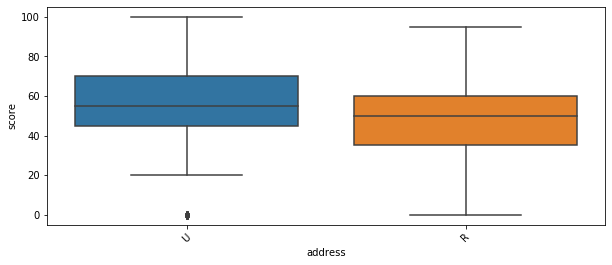

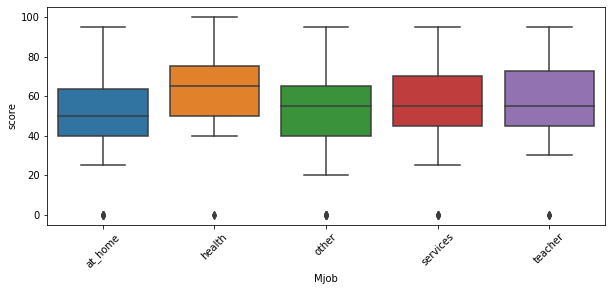

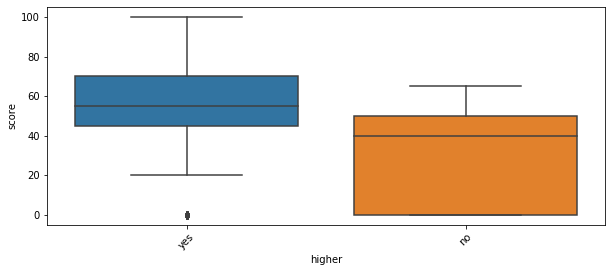

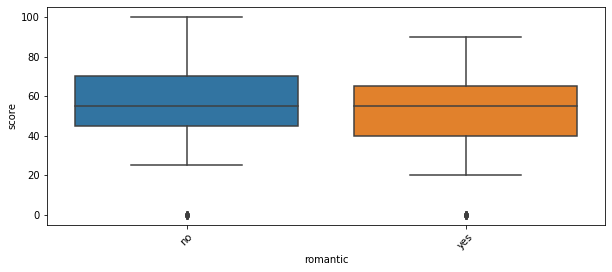

In [26]:
for column in data.columns:
    if data[column].dtype == 'O':
        fig, ax = plt.subplots(figsize=(10, 4))
        sns.boxplot(x=column,
                    y='score', 
                    data=data[data[column].isin(data[column].value_counts().index[:10])],
                    ax=ax)
        plt.xticks(rotation=45)
        plt.show()

Выведем все переменные, которые, возможно, оказывают влияние на количество баллов на госэкзамене по математике

In [27]:
signif_columns = list(data.columns)
signif_columns.remove('score')
print(signif_columns)

['age', 'address', 'Medu', 'Mjob', 'traveltime', 'studytime', 'failures', 'higher', 'romantic', 'famrel', 'goout', 'health', 'absences']


### Результаты EDA
Итак, в результате анализа влияния параметров ученика на количество набранных им баллов на госэкзамене по математике можно сделать следующие выводы:

1. Данные можно считать достаточно чистыми, так как:
    - максимальная доля пустых значений - 10,1 % (у переменной 'paid');
    - присутствует всего 2 неверных значения (одно у переменной 'Fedu' и одно у 'famrel').
2. Максимальное количество выбросов - 17 (у количественной переменной 'absences').
3. Положительная корреляция имеется с переменными (по убыванию корреляции): 'Medu', 'studytime', 'absences', 'famrel'. Здесь неожиданной оказалась положительная корреляция с количеством пропущенных занятий 'absences'.
4. Отрицательная корреляция имеется с переменными (по убыванию корреляции): 'failures', 'age', 'goout', 'traveltime', 'health'. Здесь неочевидными оказались отрицательные корреляции с возрастом 'age' и здоровьем 'health'.
5. Важные для построения модели категориальные переменные: 'address', 'Mjob', 'higher', 'romantic'.